In [161]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [162]:
import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# 项目结论

# Thinking Engine data


Dispute monitoring report:

http://td.winnerstudio.vip:8996/#/panel/panel/39_3423



## Time since payment and install

- Time since payment: http://td.winnerstudio.vip:8996/#/tga/ide/59_22269?tab=result

- Time since install: http://td.winnerstudio.vip:8996/#/tga/ide/59_22267


Next steps: 

- Can u find the dispute ID? 
- Then from that try to find out why a unique payment is associated to multiple rows? 
- Then check if after correcting this the join of predictions and regressors does not generate a movement in the rows of the response dataset. 
- Apply corrections across the analysis including the dashboards

# Response

The objective also is to find the measure of success. So the model needs to fit well the probabilities over time.

DECISION I 

- Consider only payments before the last 60 days: Reason, some of those payments can be succeptible of being disputed but hav enot been disputed yet. 
- Consider only payers that installed the game after september: Maybe before september it is too early 
- Acorn casino iOS: Only iOS version is active

In [163]:
response_data = pd.read_csv('C:/Users/Win11/Downloads/20240314_082724_43792_46qx7.csv')
response_data.sample(5)

# Measure of performance

# Data manipulation

In [ ]:
result = response_data.copy(deep = True)
result['disputer'] =  result['new_disputer_30d']

In [168]:
# Generate a function that generates the log of a list of column names in a dataframe:
cols = ['spent_to_date', 'max_payment', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments']

column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date', 'bet_money_last_7d', 'bet_money_last_14d', 'money_games_last_7d', 'money_games_last_14d', 'chip_games_last_14d']
def log_transform_columns(df, column_names):
    new_columns = []
    for col in column_names:
        new_col_name = f'l_{col}'
        df[new_col_name] = np.log(df[col])
        new_columns.append(new_col_name)
    return df, new_columns
result, logs_columns = log_transform_columns(result, column_names)
print(logs_columns)


# Generate a function that divides all the columns in a list by the columns in another list:
def divide_columns(df, dividend_columns, divisor_columns):
    new_columns = []
    for dividend_col, divisor_col in zip(dividend_columns, divisor_columns):
        new_col_name = f'ratio_{dividend_col}_to_{divisor_col}'
        df[new_col_name] = df[dividend_col] / df[divisor_col]
        new_columns.append(new_col_name)
    return df, new_columns

dividend_columns = ['spent_to_date']
divisor_columns = ['user_matuirity', 'payments_to_date']
result, ratios_columns_1 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_1)

dividend_columns = ['max_payment_in_day', 'max_payment']
divisor_columns = ['spent_to_date', 'payments_to_date']
result, ratios_columns_2 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_2)

dividend_columns = ['money_games_working_hours_last_14d']
divisor_columns = ['money_games_last_14d']
result, ratios_columns_3 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_3)

# Generate a function that generates all the multiplications between the columns in a dataframe
def generate_multiplications(df):
    new_columns = []
    columns = df.columns
    for i, col1 in enumerate(columns):
        for col2 in columns[i + 1:]:
            new_col_name = f'{col1}_x_{col2}'
            df[new_col_name] = df[col1] * df[col2]
            new_columns.append(new_col_name)
    return df, new_columns
# result, interacations_columns = generate_multiplications(result, column_names)


# Generate a function that generates k dummy variables in each column in list, where k is the number of quantiles - 1. The lowest quantile is left
column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date', 'max_bet']
def generate_quantile_dummies(df, column_names, num_quantiles):
    new_columns = []
    for col in column_names:
        quantiles = df[col].quantile(np.linspace(0, 1, num_quantiles + 1)).reset_index(drop = True)
        for i in range(1, num_quantiles):
            new_col = f'{col}_quantile_{i}'
            df[new_col] = (df[col] > quantiles[i-1]).astype(int)
            new_columns.append(new_col)
    return df, new_columns
result, quantile_columns = generate_quantile_dummies(result, column_names, num_quantiles = 10)
print(quantile_columns)

# Generate a function that generates a dummy variable in each column in list, where 1 if the value is an outlier, and 0 otherwise.
column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date']
def generate_outlier_dummies(df, column_names):
    new_columns = []
    for col in column_names:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        new_col_name = f'{col}_outlier'
        df[new_col_name] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)
        new_columns.append(new_col_name)
    return df, new_columns
result, outlier_columns = generate_outlier_dummies(result, column_names)
print(outlier_columns)


KeyError: 'spent_last_7_days'

In [170]:
# cols = ['max_spent', 'daily_spent', 'spent_deviation', 'spent_ratio', 'time_to_payment', 'payments']
# cols = ['spent_to_date', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments'] + logs_columns + ratios_columns_1 + ratios_columns_2 + ratios_columns_3 + quantile_columns + outlier_columns
cols = ['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date'
        ,  'payments_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']

print(cols)

print(len(result[cols].columns))
# time_pay_to_dispute	time_to_dispute	payments_to_date	payments_last_7_days	spent_last_7_days	spent_to_date	max_payment	max_payment_in_day	std_payments	disputer_lt_30d
result = result.replace([np.inf, -np.inf, np.nan], 0)
print(len(result[cols].columns))

result.loc[:, (result != result.iloc[0]).any()]
len(result[cols].columns)


['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date', 'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']
13
13


13

# Exploration of overfit and explanainable model

In [172]:

def create_model(criterion, depth, leaf_size):

    # preprocessor = ColumnTransformer(
    #     transformers = [
    #         ('scaler', StandardScaler(), cols)
    #     ],
    #     remainder='passthrough'
    # )

    # Create the pipeline
    pipe = Pipeline([
        # ('preprocessor', preprocessor),
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
        # ('regressor', RandomForestClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [ ]:
validation_sets = 3
response_data['date'] = pd.to_datetime(response_data['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
response_data['validation_set_id'] = pd.qcut(response_data['date'].values, validation_sets)
response_data.groupby('validation_set_id').size()

In [173]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['log_loss']
depths = [4]
leaf_sizes = [100]
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    # train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


In [174]:
# all_model_results.groupby(['Iteration', 'Test at', 'Model']).mean()
amrgb = all_model_results.groupby('Iteration')[['accuracy', 'precission']].mean().sort_values(by = 'accuracy', ascending = False).reset_index(drop = False)
amrgb


,Iteration,accuracy,precission
0,log_loss - 4 - 100,0.994481,0.0


In [175]:
# all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 350']['Model'].values[0]
all_model_results[all_model_results['Iteration'] == 'log_loss - 7 - 50']['Model'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

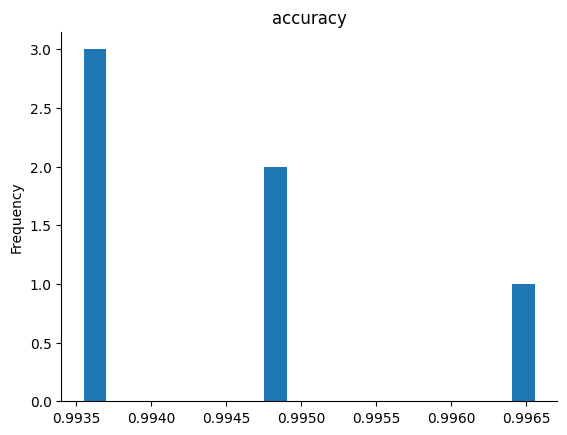

In [133]:
# @title accuracy

from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [176]:
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 4 - 100']['Model'].values[0]
payment_cols
train_data.columns

Index(['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d',
       'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date',
       'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std',
       'money_games_to_date', 'disputer'],
      dtype='object')

In [177]:
train_data.columns
train_data['Predicted_Probability_A'] = clf.predict_proba(train_data[cols])[:, 1]  # Probability of class 1
train_data['True_Label'] = train_data[f'disputer']

import plotly.graph_objects as go

# Initialize lists to store results
thresholds = np.linspace(0, 0.9, 100)  # Thresholds from 0 to 30%
bad_users = []
correct_bad_users = []

# Iterate through thresholds
for threshold in thresholds:
    # Classify users as "bad" if their probability is above the threshold
    classified_as_bad = train_data['Predicted_Probability_A'] > threshold
    
    # Count the total number of users classified as "bad"
    total_bad = np.sum(classified_as_bad)
    
    # Count the number of correctly classified "bad" users
    correctly_classified_bad = np.sum(classified_as_bad & (train_data['True_Label'] == 1))
    
    # Append results to lists
    bad_users.append(total_bad)
    correct_bad_users.append(correctly_classified_bad)

# Convert total bad users to percentage
total_users = len(train_data)
bad_users_percentage = [bad / total_users * 100 for bad in bad_users]

# Plot the results using Plotly with a bigger figure size
fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=bad_users_percentage, mode='lines', name='Total Bad Users (%)'))
fig.add_trace(go.Scatter(x=thresholds, y=correct_bad_users, mode='lines', name='Correctly Classified Bad Users'))
fig.update_layout(title='Number of Users vs Threshold', xaxis_title='Threshold', yaxis_title='Number of Users', legend=dict(x=0, y=1), width=2000, height=1000)
fig.show()

In [178]:
def calculate_percentage(df, threshold):
    """
    Calculate the percentage of observations with a probability greater than or equal to the threshold
    and the percentage of cases above the threshold that are actually true (1), out of all the true cases.
    
    Args:
    - df (DataFrame): DataFrame containing actual observations and predicted probabilities.
                      It should have columns 'Predicted_Probability' and 'True_Label'.
    - threshold (float): Threshold value for classification.
    
    Returns:
    - percent_above_threshold (float): Percentage of observations with a probability greater than or equal to the threshold.
    - percent_true_above_threshold (float): Percentage of cases above the threshold that are actually true (1),
                                             out of all the true cases.
    """
    # Filter rows where predicted probability is greater than or equal to the threshold
    above_threshold = df['Predicted_Probability'] >= threshold
    
    # Calculate percentage of observations above the threshold
    percent_above_threshold = (above_threshold.sum() / len(df)) * 100
    
    # Filter rows where predicted probability is above the threshold and true label is 1
    true_above_threshold = df.loc[above_threshold, 'True_Label'] == 1
    
    # Calculate percentage of true cases above the threshold out of all true cases
    if df['True_Label'].sum() > 0:
        percent_true_above_threshold = (true_above_threshold.sum() / df['True_Label'].sum()) * 100
    else:
        percent_true_above_threshold = 0  # Handle case where there are no true cases
    
    return percent_above_threshold, percent_true_above_threshold

train_data.columns
train_data['Predicted_Probability'] = clf.predict_proba(train_data[cols])[:, 1]  # Probability of class 1
train_data['True_Label'] = train_data[f'disputer']

In [179]:
# Assuming you have already calculated 'Predicted_Probability_A' and 'True_Label' columns in your DataFrame 'train_data'

# Set the threshold value
threshold = 0.024 # Adjust as needed

# Apply the function to calculate percentages
percent_above_threshold, percent_true_above_threshold = calculate_percentage(train_data, threshold)

# Print the results
print("Percentage of observations with probability greater than or equal to the threshold:", percent_above_threshold)
print("Percentage of true cases above the threshold out of all true cases:", percent_true_above_threshold)


Percentage of observations with probability greater than or equal to the threshold: 2.9655620532813516
Percentage of true cases above the threshold out of all true cases: 31.958762886597935


In [138]:
quantile_values

[0.0,
 0.0008988186954288649,
 0.0008988186954288649,
 0.0008988186954288649,
 0.0008988186954288649,
 0.0032122559920929085,
 0.003474718427989456,
 0.003474718427989456,
 0.010882708585247884,
 0.12389380530973451]

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


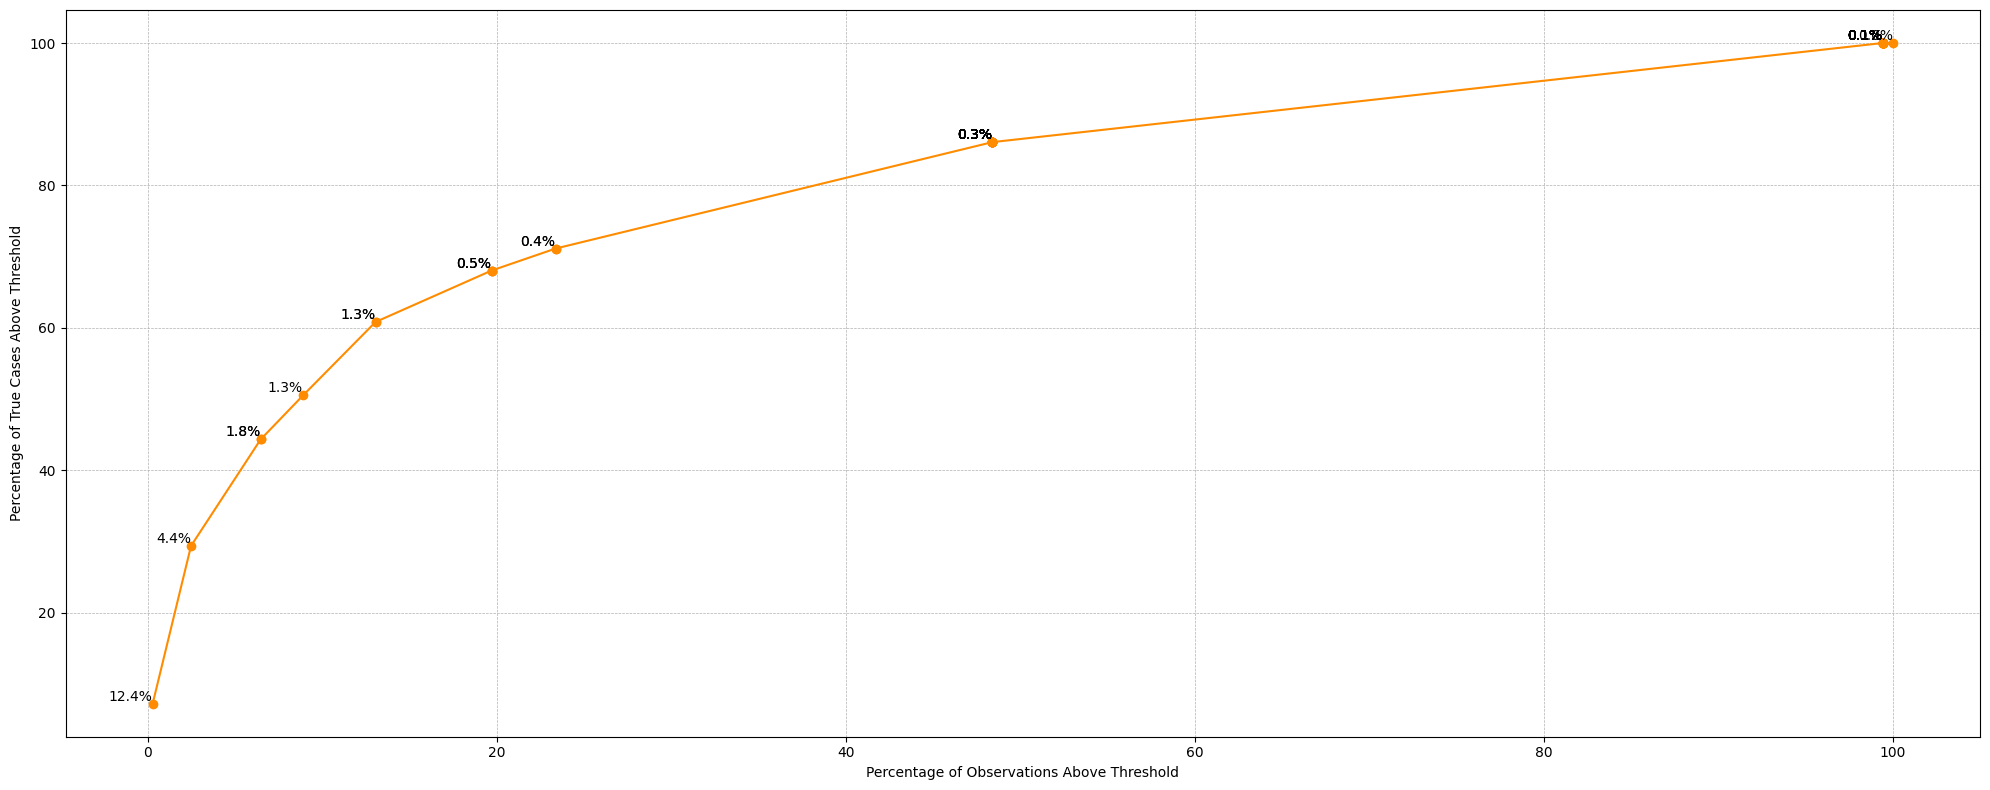

In [180]:
quantiles = np.linspace(0, 1, 51)  # Divide the range [0, 1] into 10 quantiles
print(quantiles)
# Initialize lists to store results
percent_above_thresholds = []
percent_true_above_thresholds = []
quantile_values = []

# Iterate through quantiles
for quantile in quantiles:
    threshold = train_data['Predicted_Probability'].quantile(quantile)
    percent_above_threshold, percent_true_above_threshold = calculate_percentage(train_data, threshold)
    percent_above_thresholds.append(percent_above_threshold)
    percent_true_above_thresholds.append(percent_true_above_threshold)
    quantile_values.append(threshold)

# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(percent_above_thresholds, percent_true_above_thresholds, marker='o', color='darkorange', linestyle='-')
for i, txt in enumerate(quantile_values):
    plt.annotate(f'{txt*100:.1f}%', (percent_above_thresholds[i], percent_true_above_thresholds[i]), fontsize=10, ha='right', va='bottom')
plt.xlabel('Percentage of Observations Above Threshold')
plt.ylabel('Percentage of True Cases Above Threshold')
# plt.title('Percentage of True Cases vs Percentage of Observations Above Threshold')
plt.title('')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [95]:

# Rule identifier 
node_size = 0.02
found = (0.10 * node_size) 
total = 0.01

impact_dispute_rate = found / total
impact_users = total 

print(impact_dispute_rate, impact_users)

0.2 0.01


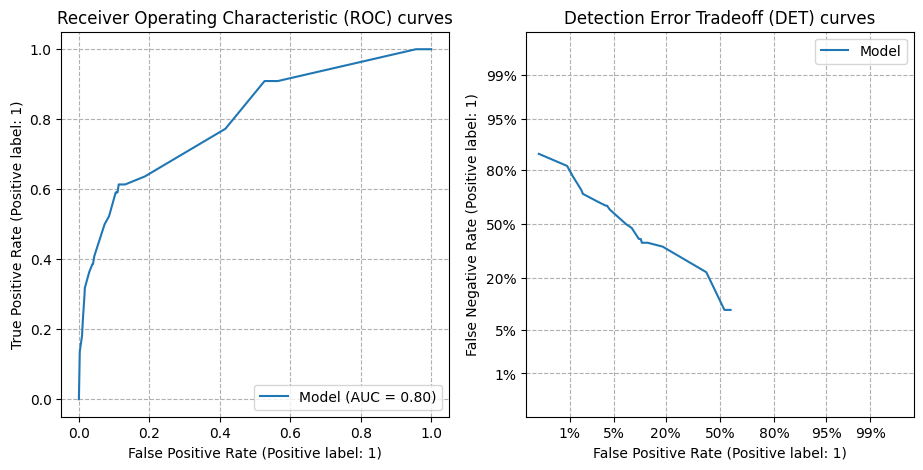

In [34]:

import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

# for name, clf in classifiers.items():
#     clf.fit(X_train, y_train)

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name='Model')
DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name='Model')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date', 'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']


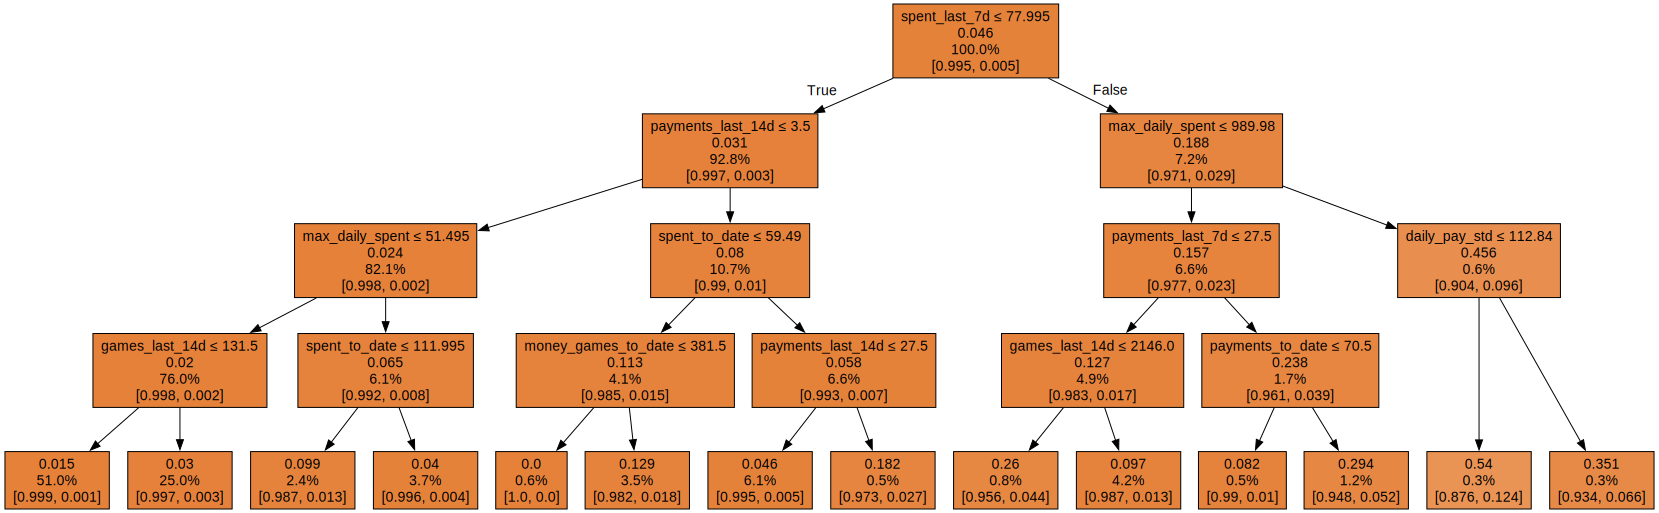

In [182]:
# from sklearn import tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier
# clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 350']['Model'].values[0][0]
# clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 70']['Model'].values[0][0]
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 4 - 100']['Model'].values[0][0]

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

print(cols)
# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                        #    ,  rotate = True
                           ,  special_characters=True)

graphviz.Source(dot_data)
# print(dot_data)



If approapiate you can rebalance the number of users

In [25]:
# response_data[response_data['daily_spent'] >= 53.274][response_data['spent_deviation'] <= 4.622].head(20)
# response_data[response_data['daily_spent'] >= 53.274][response_data['payments'] <= 7.5].head(20)
# response_data[response_data['daily_spent'] > 18.215][response_data['payments'] <= 3.5].head(20)
# # response_data[response_data['daily_spent'] > 18.215][response_data['payments'] <= 3.5]

The conclusion is that the model looks for high payers, and it barely cares about withdrawal patterns.

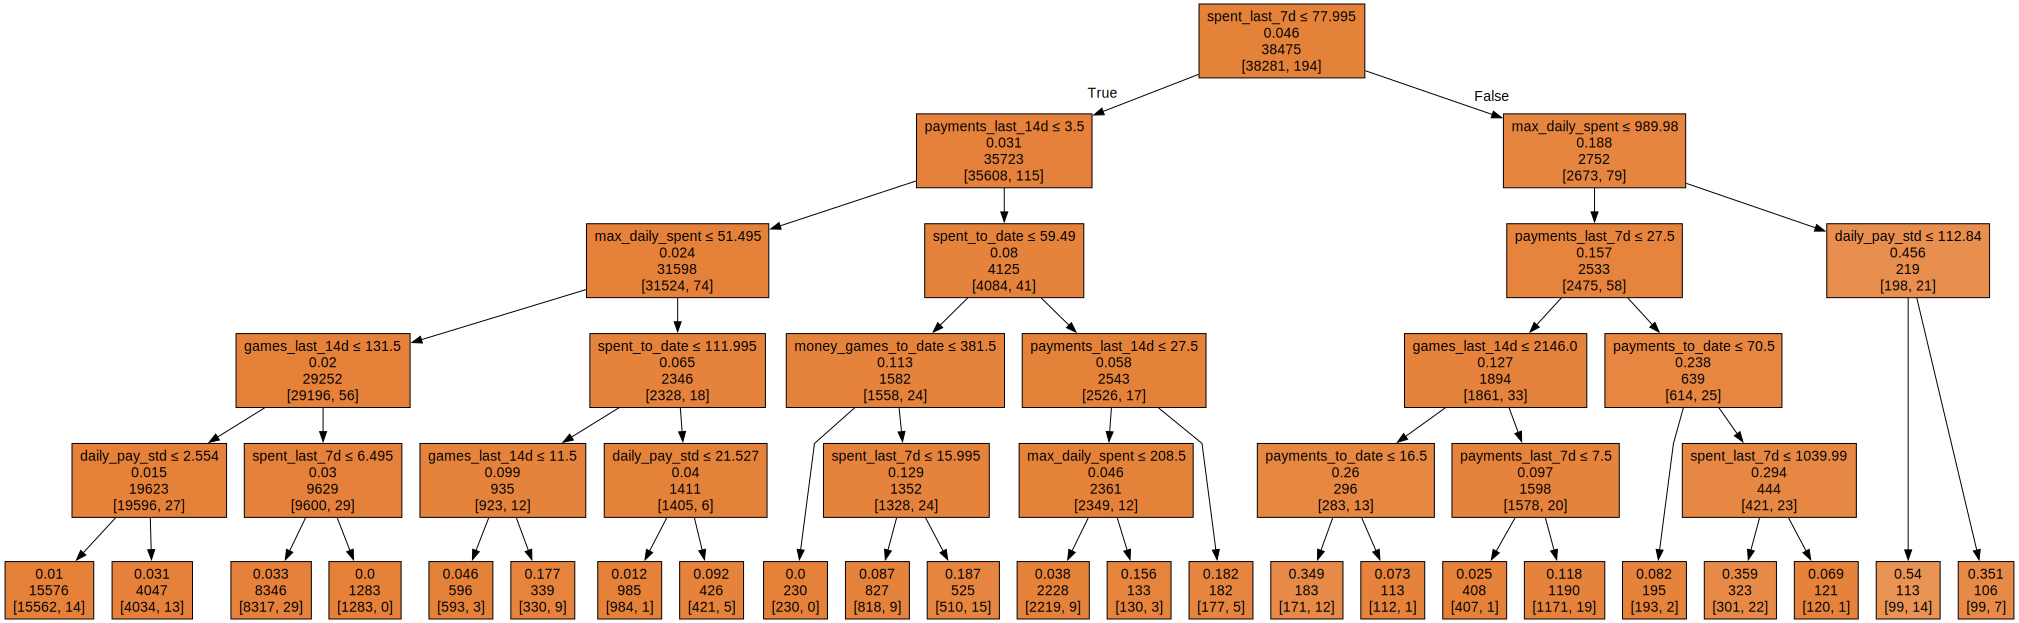

In [46]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled = True
                           ,  leaves_parallel = True
                          #  ,  proportion = True
                           ,  rounded = False
                           ,  special_characters = True)

graphviz.Source(dot_data)



# Real model selection

In [47]:
validation_sets = 3
# result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
# result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()


validation_set_id
(20231001.999, 20231216.0]    13491
(20231216.0, 20240104.0]      12199
(20240104.0, 20240122.0]      12785
dtype: int64

In [48]:
result['validation_set_id'].unique()

[(20231001.999, 20231216.0], (20231216.0, 20240104.0], (20240104.0, 20240122.0]]
Categories (3, interval[float64, right]): [(20231001.999, 20231216.0] < (20231216.0, 20240104.0] < (20240104.0, 20240122.0]]

In [49]:

train_data =  result[result['validation_set_id'] != result['validation_set_id'].unique()[2]][payment_cols]
test_data =  result[result['validation_set_id'] == result['validation_set_id'].unique()[2]][payment_cols]

X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

# X_train.sample(5)
X_test.sample(5)

,spent_to_date,max_payment,payments_last_14d,payments_last_7d,games_last_14d,games_last_7d,games_to_date,payments_to_date,spent_last_14d,spent_last_7d,max_daily_spent,daily_pay_std,money_games_to_date
11743,3.0,3.0,0,0,0.0,0.0,192.0,1,0.0,0.0,3.0,0.639602,164.0
13973,3.0,3.0,0,0,0.0,0.0,773.0,1,0.0,0.0,3.0,0.639602,432.0
8154,80.0,20.0,2,2,5255.0,1609.0,9134.0,7,30.0,30.0,30.0,6.119304,1000.0
3642,6.0,2.0,0,0,0.0,0.0,287.0,3,0.0,0.0,4.0,0.588490,125.0
29068,8.0,5.0,0,0,237.0,231.0,655.0,2,0.0,0.0,5.0,1.216766,306.0


In [30]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

# class_weight
lr              = LogisticRegression(C = 1.0, max_iter = 180, n_jobs = 5)
lr              = LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5)
# I want a model  

# gnb_isotonic    = CalibratedClassifierCV(gnb, cv = 2, method="isotonic")
# gnb_sigmoid     = CalibratedClassifierCV(gnb, cv = 2, method="sigmoid")
# Random_Forest_1 = RandomForestClassifier(min_samples_leaf = 25, n_jobs = 5)
Random_Forest_40  = RandomForestClassifier(min_samples_leaf = 40, n_jobs = 5)
Random_Forest_200 = RandomForestClassifier(min_samples_leaf = 200, n_jobs = 5)
dt                = DecisionTreeClassifier(min_samples_leaf = 350)

clf_list = [
    (lr, "Logistic")
    , (dt, "Classification Tree")
    , (Random_Forest_40, "Random_Forest_40")
    , (Random_Forest_200, "Random_Forest_200")
]

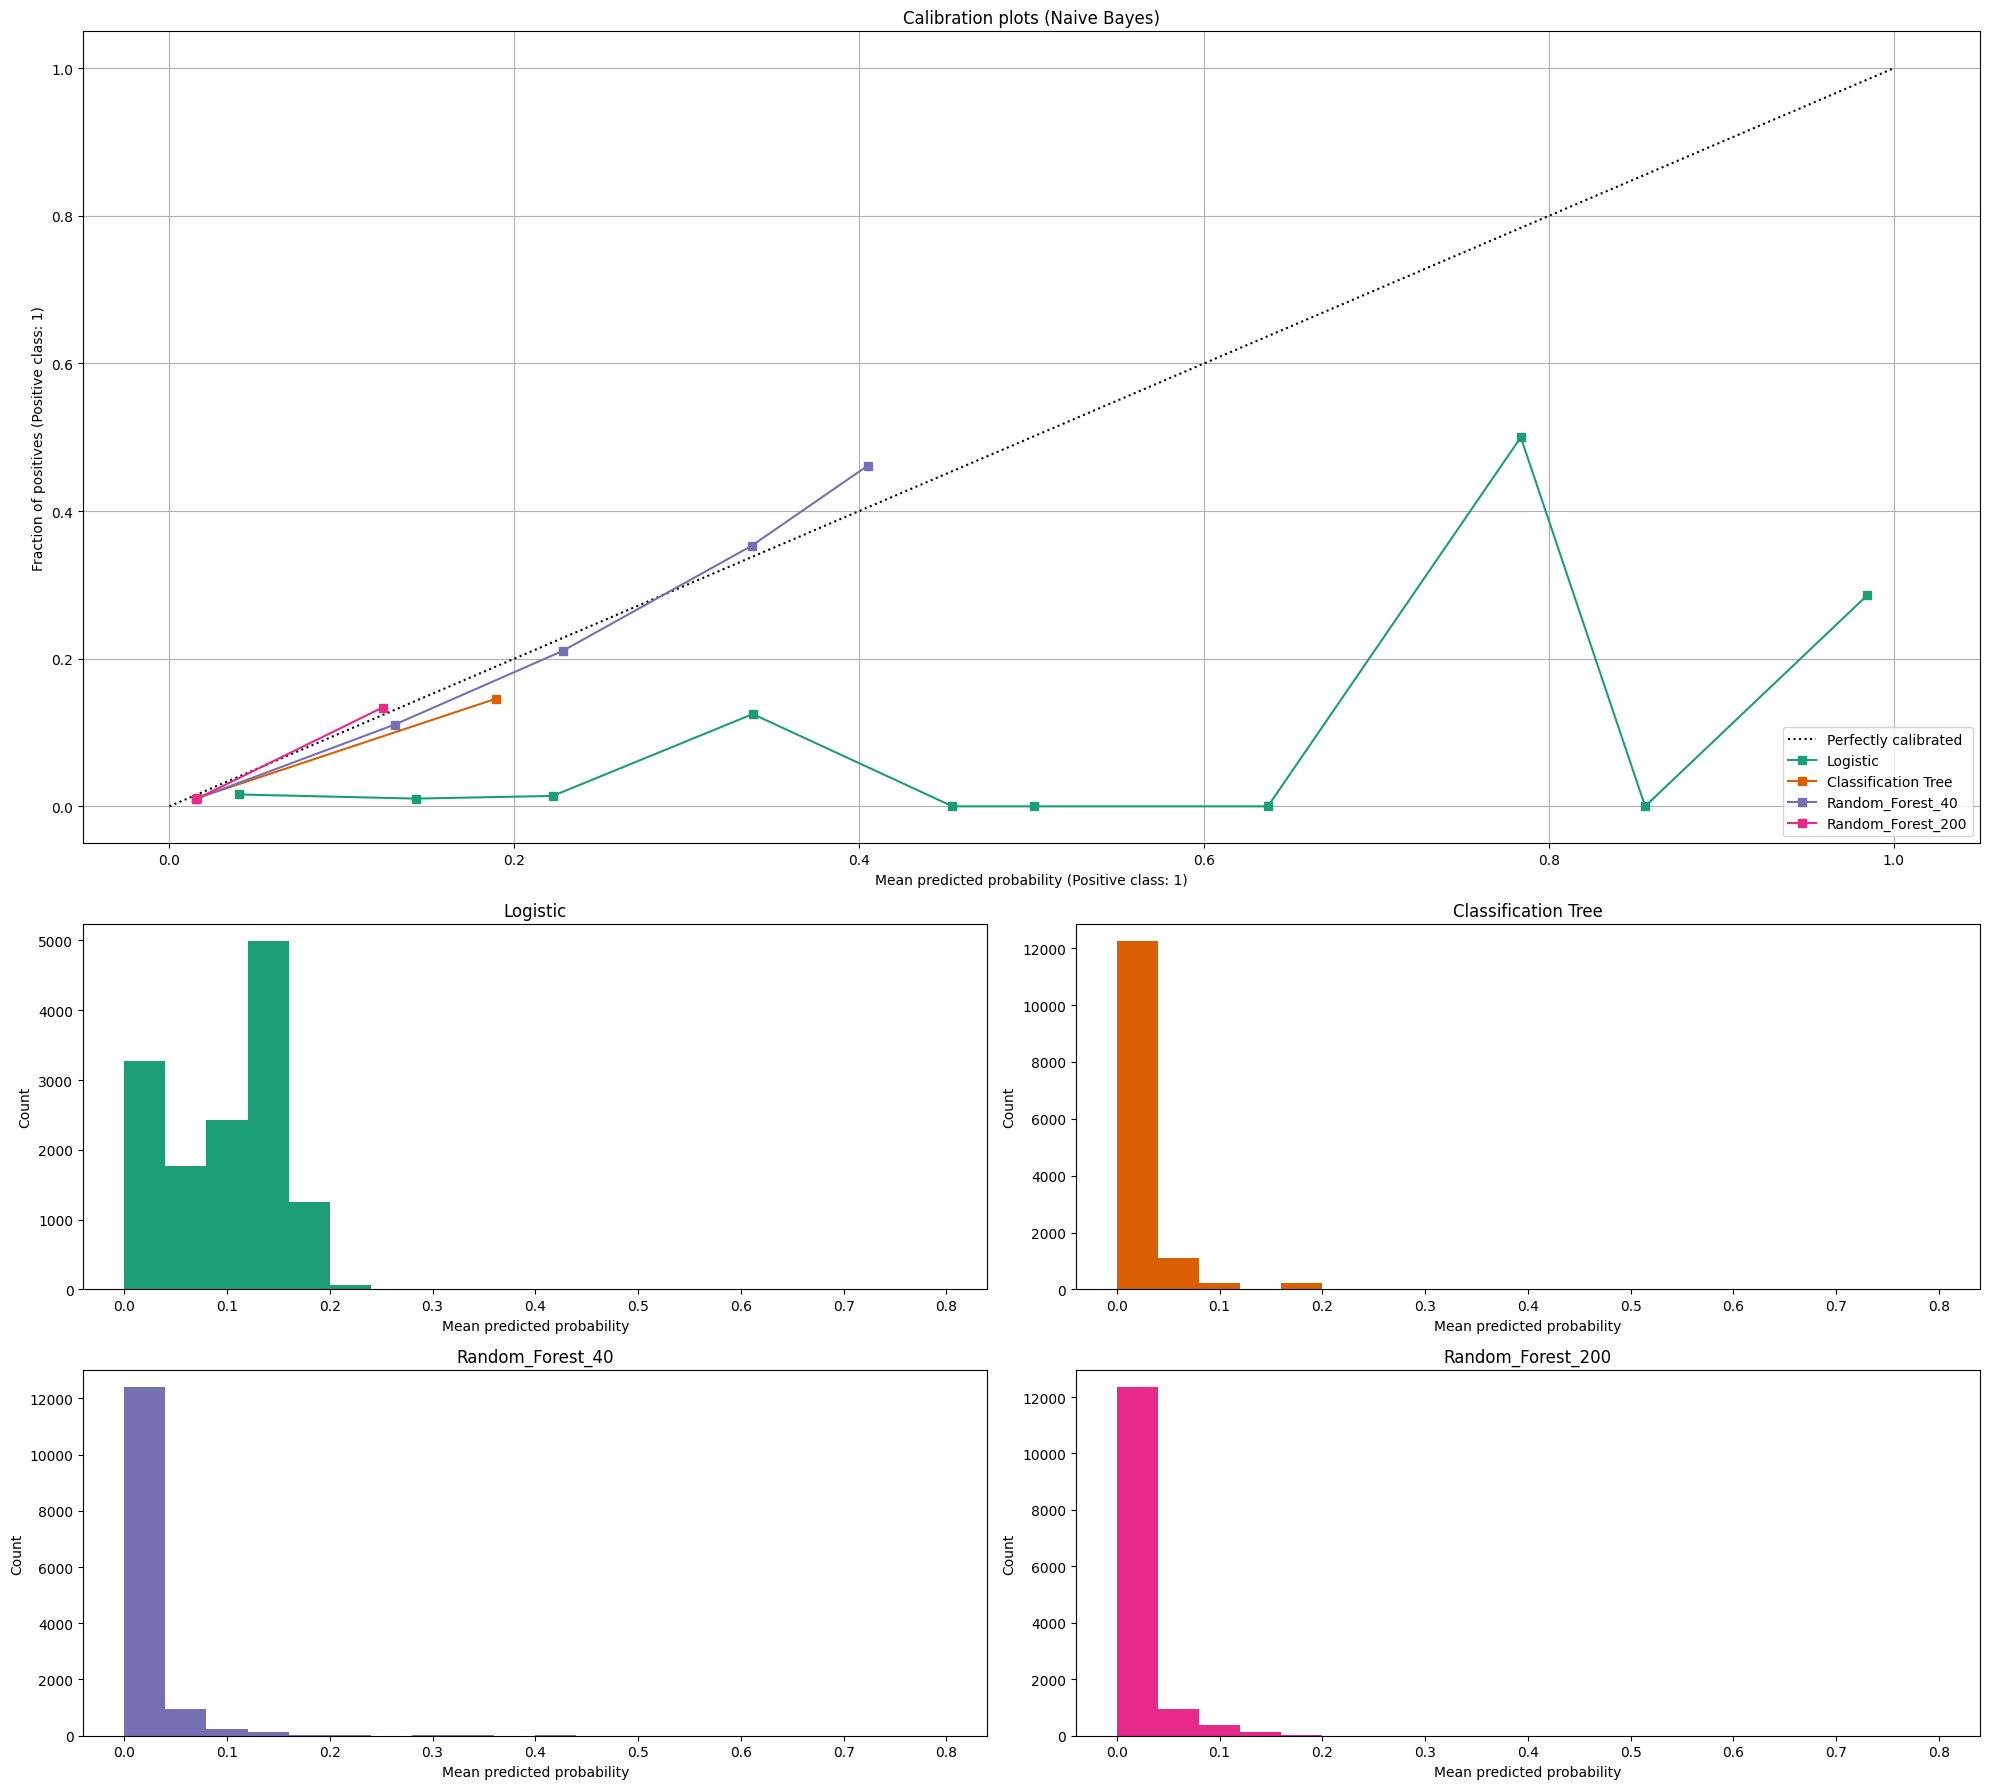

In [31]:
fig = plt.figure(figsize=(20, 18))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")
fitted_models = {}

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    fitted_models[name] = clf

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins = 10,
        name = name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 0.8),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# I want to add more details to the plot 

plt.tight_layout()
plt.show()

In [57]:
Random_Forest_1.fit(X_train[cols], y_train)
predictions = Random_Forest_1.predict(X_test[cols])
prob_predictions = Random_Forest_1.predict_proba(X_test[cols])
accuracy = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions)


In [58]:
predictions
prob_predictions[:, 1].max()

0.5177635281705086

In [32]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

KeyboardInterrupt: 

In [60]:
X_test

,spent_to_date,max_payment,payments_to_date,user_matuirity,payments_last_7_days,spent_last_7_days,max_payment_in_day,std_payments
562473,127.98,29.99,14,43,0,0.0,83.98,33.139343
562474,127.98,29.99,14,42,0,0.0,83.98,33.139343
562475,127.98,29.99,14,41,0,0.0,83.98,33.139343
562476,127.98,29.99,14,40,0,0.0,83.98,33.139343
562477,127.98,29.99,14,39,0,0.0,83.98,33.139343
...,...,...,...,...,...,...,...,...
819021,10.00,10.00,1,15,0,0.0,10.00,0.000000
819022,5.00,5.00,1,15,0,0.0,5.00,0.000000
819023,31.00,5.00,8,15,0,0.0,19.00,4.949747
819024,40.00,10.00,6,15,1,5.0,15.00,5.773503


0.0
1.0



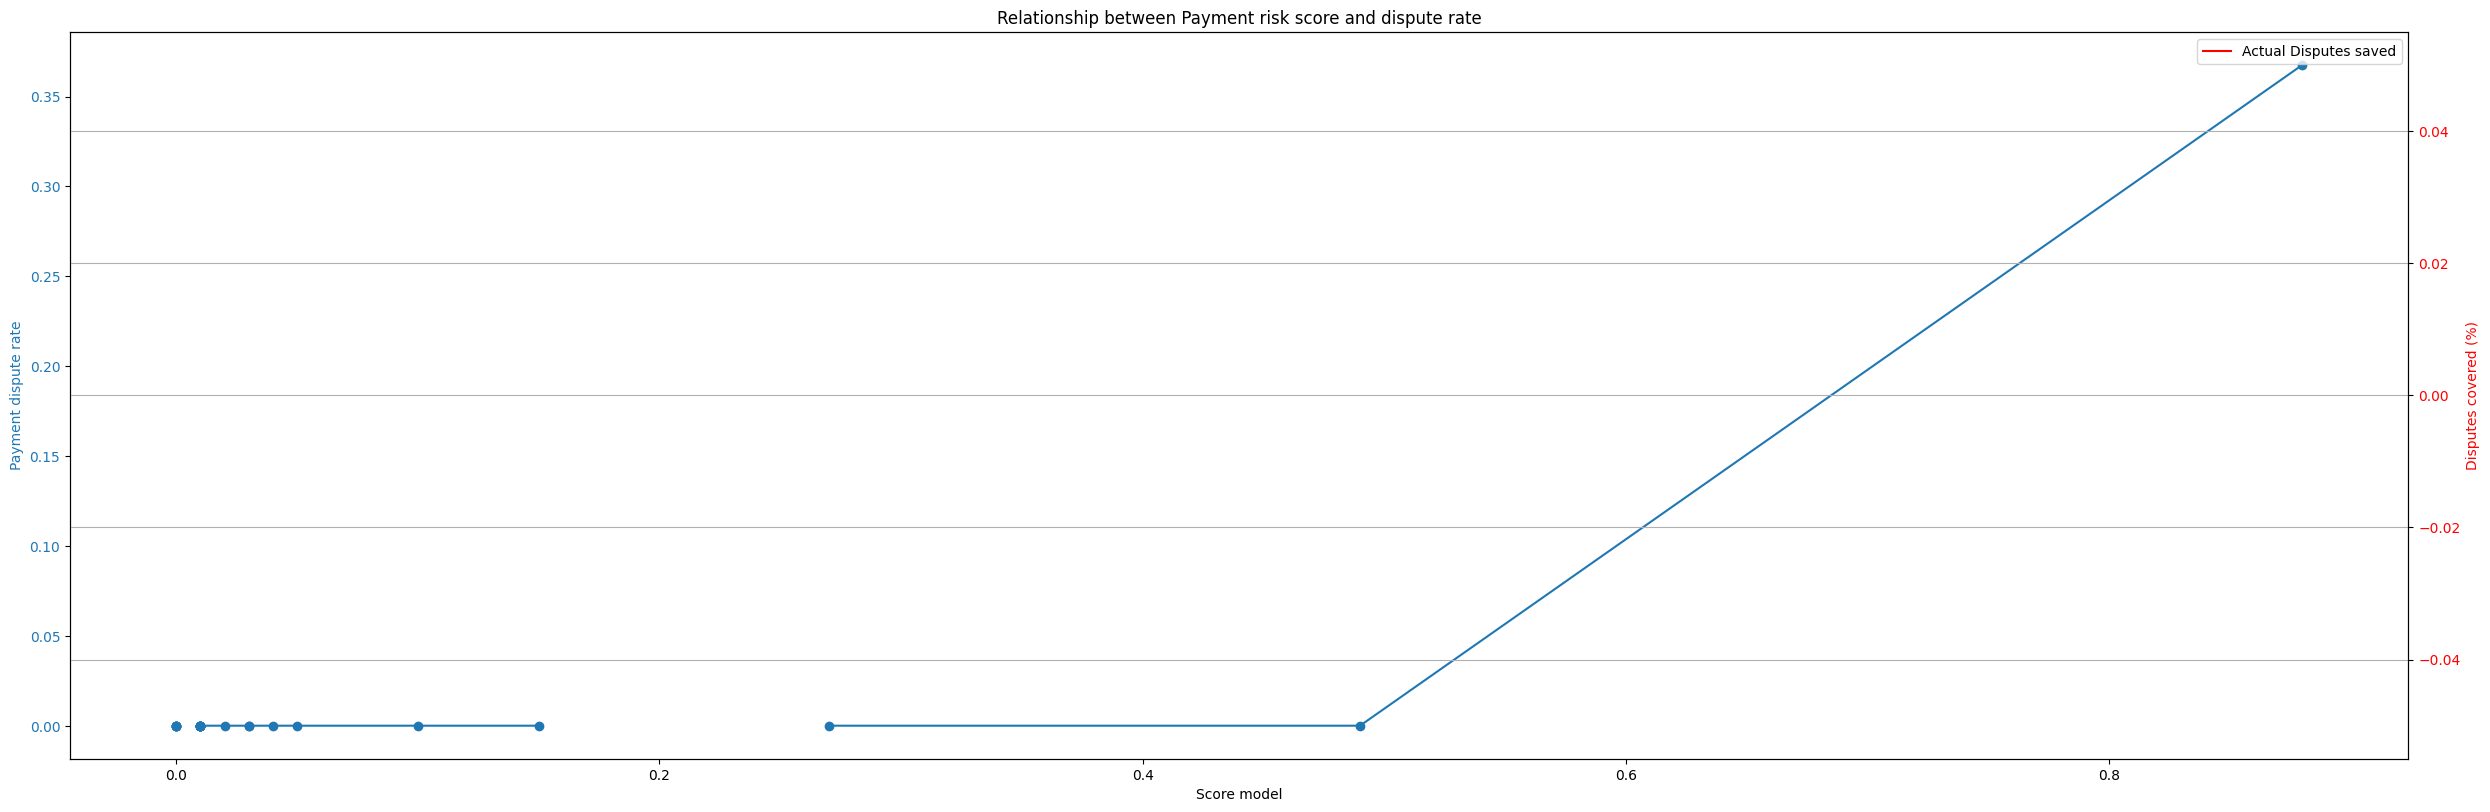

In [42]:
# Don't run
X_test_old = X_test.copy(deep = True)
X_test = X_test_old.copy(deep = True)

X_test['pred'] = Random_Forest.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run
print(X_test['pred'].min())
print(X_test['pred'].max())
print('')

# Calculate 200 equally sized groups
quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
percentiles = np.percentile(X_test['pred'], quantiles)

# Step 1: Calculate the quantiles of 'prob' column
quantiles = X_test['pred'].quantile([i/100 for i in range(1, 101)])

# # Step 2: Calculate the mean of 'is_dispute' for each quantile range
mean_values = []
for i in range(len(quantiles)):

    lower_quantile = quantiles.reset_index(drop = True)[i]

    if i < len(quantiles) - 1:
      upper_quantile = quantiles.reset_index(drop = True)[i + 1]
    else:
      upper_quantile = 100

    subset = X_test[(X_test['pred'] >= lower_quantile) & (X_test['pred'] < upper_quantile)]
    mean_dispute = subset['is_dispute'].mean()
    mean_values.append(mean_dispute)

# Create line plot
x_values = (np.concatenate((percentiles[1:], [lower_quantile]))).round(4)[:-1]
y_values = mean_values[:-1]

# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize = (25, 8))

# Plot the first line on the first Y-axis
color = 'tab:blue'
ax1.set_xlabel('Score model')
ax1.set_ylabel('Payment dispute rate', color=color)
ax1.plot((x_values * 100).round(2), y_values, marker = 'o', color=color)
ax1.tick_params(axis='y', labelcolor = color)

# Create a secondary Y-axis for the second plot
ax2 = ax1.twinx()

quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
quantiles = np.percentile(X_test['pred'], quantiles)

# Step 2: Calculate average of 'id_dispute' for each quantile
average_id_dispute = []
for quantile in quantiles:
    avg_id_dispute = X_test[X_test['pred'] <= quantile]['is_dispute'].sum()
    average_id_dispute.append(avg_id_dispute)

# Step 3: Create line plot
x_values = (np.concatenate((quantiles[1:], [lower_quantile]))*100).round(2)[:-1]
y_values = 1 - (average_id_dispute/(average_id_dispute[-1]))[:-1]
ax2.plot(x_values, y_values, label = 'Actual Disputes saved', color = 'red')
ax2.set_ylabel('Disputes covered (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 0)
del X_test['pred']
del X_test['is_dispute']

fig.tight_layout()
plt.title('Relationship between Payment risk score and dispute rate')
plt.grid(True)
plt.show()


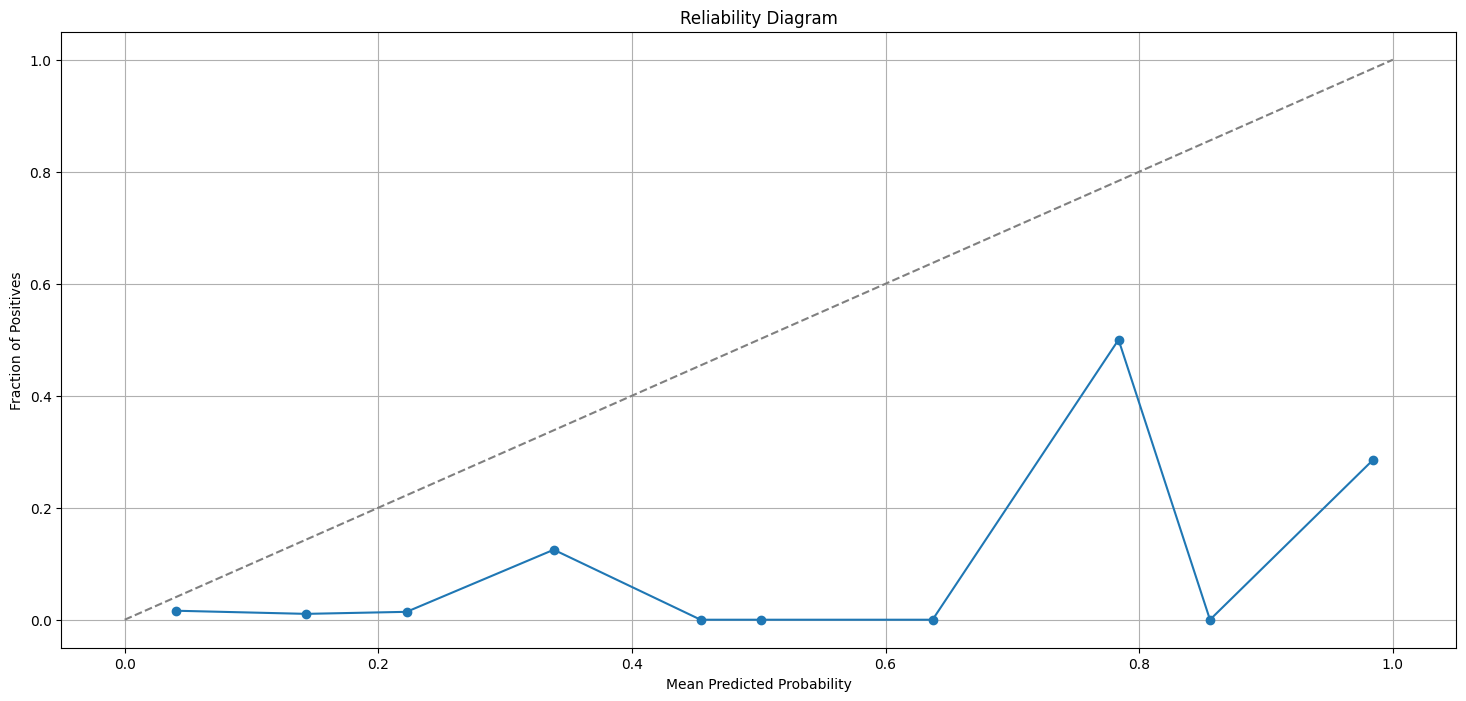

In [33]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

X_test['pred'] = lr.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run

# Compute calibration curve
prob_true, prob_pred = calibration_curve(X_test['is_dispute'], X_test['pred'] , n_bins=10, strategy='uniform')

# Plot reliability diagram
plt.figure(figsize=(18, 8))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for perfect calibration
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.grid(True)
plt.show()


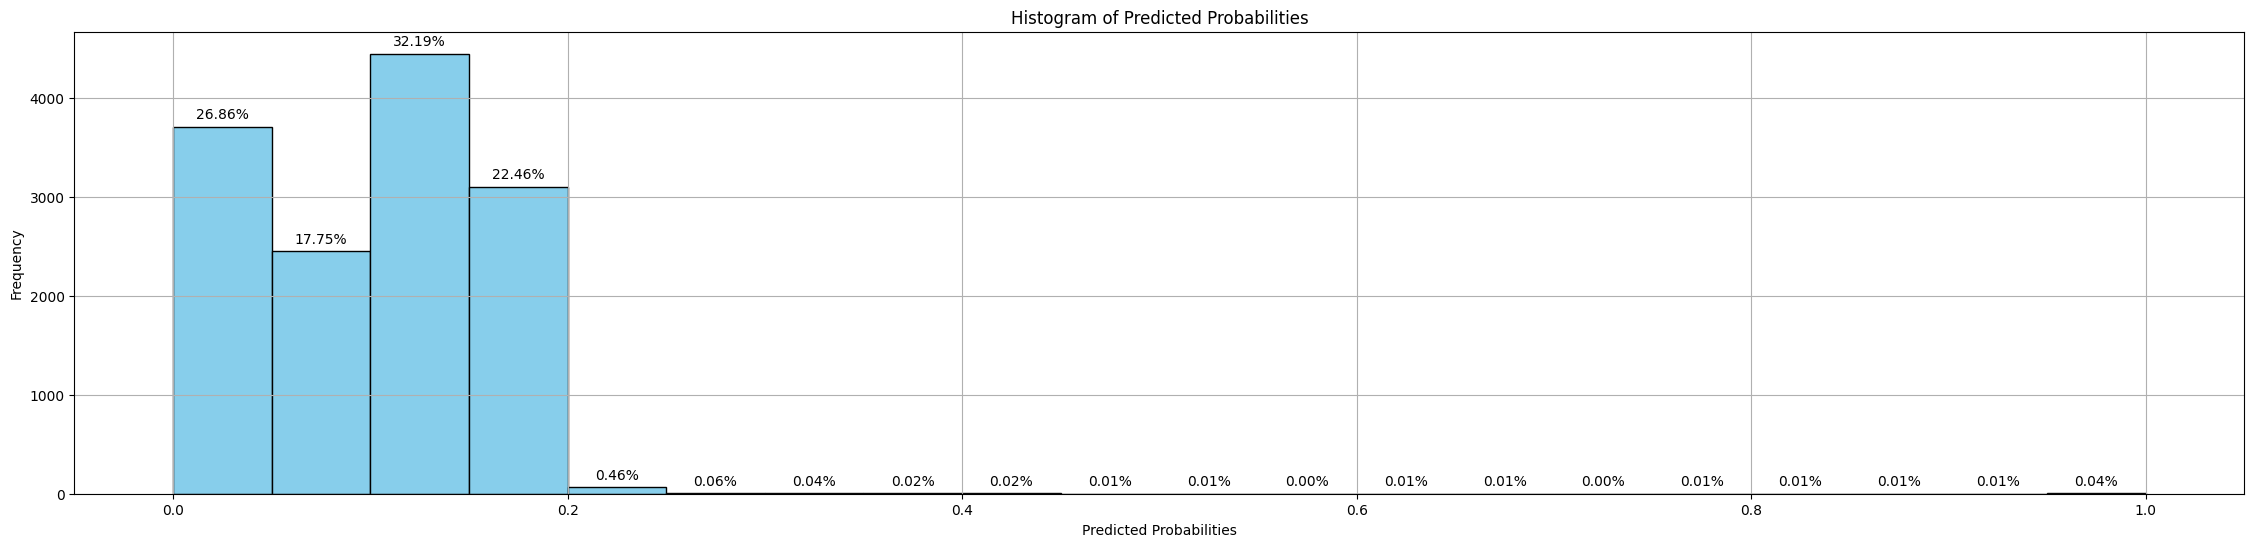

In [34]:
import matplotlib.pyplot as plt

# Assuming X_test['pred'] contains the predicted probabilities
pred_probabilities = X_test['pred']

# Plot histogram
plt.figure(figsize=(28, 6))
n, bins, patches = plt.hist(pred_probabilities, bins=20, color='skyblue', edgecolor='black')

# Compute percentages for each bin
bin_percentages = [(count / len(pred_probabilities)) * 100 for count in n]

# Add labels to bars
for patch, percentage in zip(patches, bin_percentages):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 50, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=1_000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=1,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    # "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025, dual="int")),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1
    ),
}

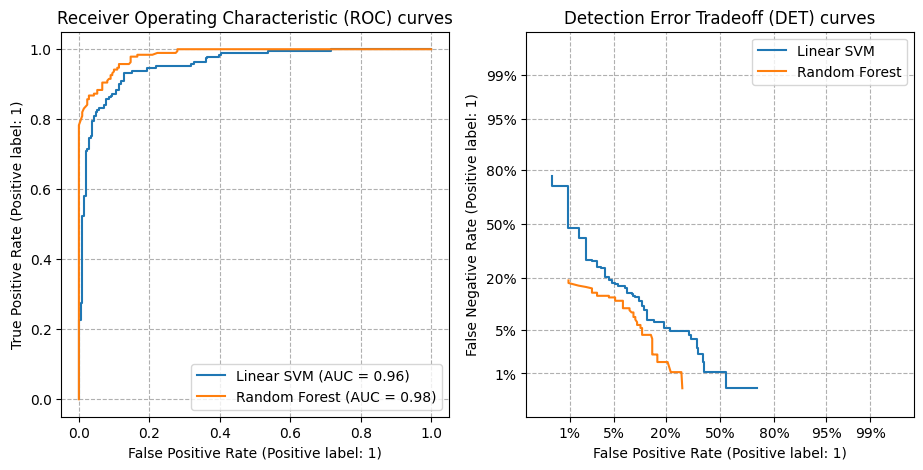

In [11]:
import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

# Real Cross-Validation 

This part I want to implement a piece of code that breaks the training into multiple parts. Then it predicts and allocates probabilities. Subsequently it generates a visual and reports the metrics that I need to make decisions. 

For example, I want to see the number of users over time. So, I need to do the following: 

1. Break the dataset 
2. Do a model without one piece and calcualte the predictions and the actuals - You can save this 
3. Return the desired metrics - You can save this 
4. plot the results - You can save this 
5. Calcualte the overall metrics. For example, you can calculate the mean metric, and you can plot all the sampled data. 


### Break the dataset 

In [51]:
# result = result[result['user_matuirity'] == 15].reset_index(drop = False)
# result

In [52]:
validation_sets = 4
# result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()

validation_set_id
(20231001.999, 20231210.0]    9782
(20231210.0, 20231226.0]      9943
(20231226.0, 20240109.0]      9392
(20240109.0, 20240122.0]      9358
dtype: int64

In [53]:
result.groupby('validation_set_id')['disputer'].mean()


validation_set_id
(20231001.999, 20231210.0]    0.006236
(20231210.0, 20231226.0]      0.005934
(20231226.0, 20240109.0]      0.004685
(20240109.0, 20240122.0]      0.003206
Name: disputer, dtype: float64

Warning: The plot belows shows that there is a problem with the data utilised. Overall I think we're considereing to late users and too later payments to obtain dispute rates

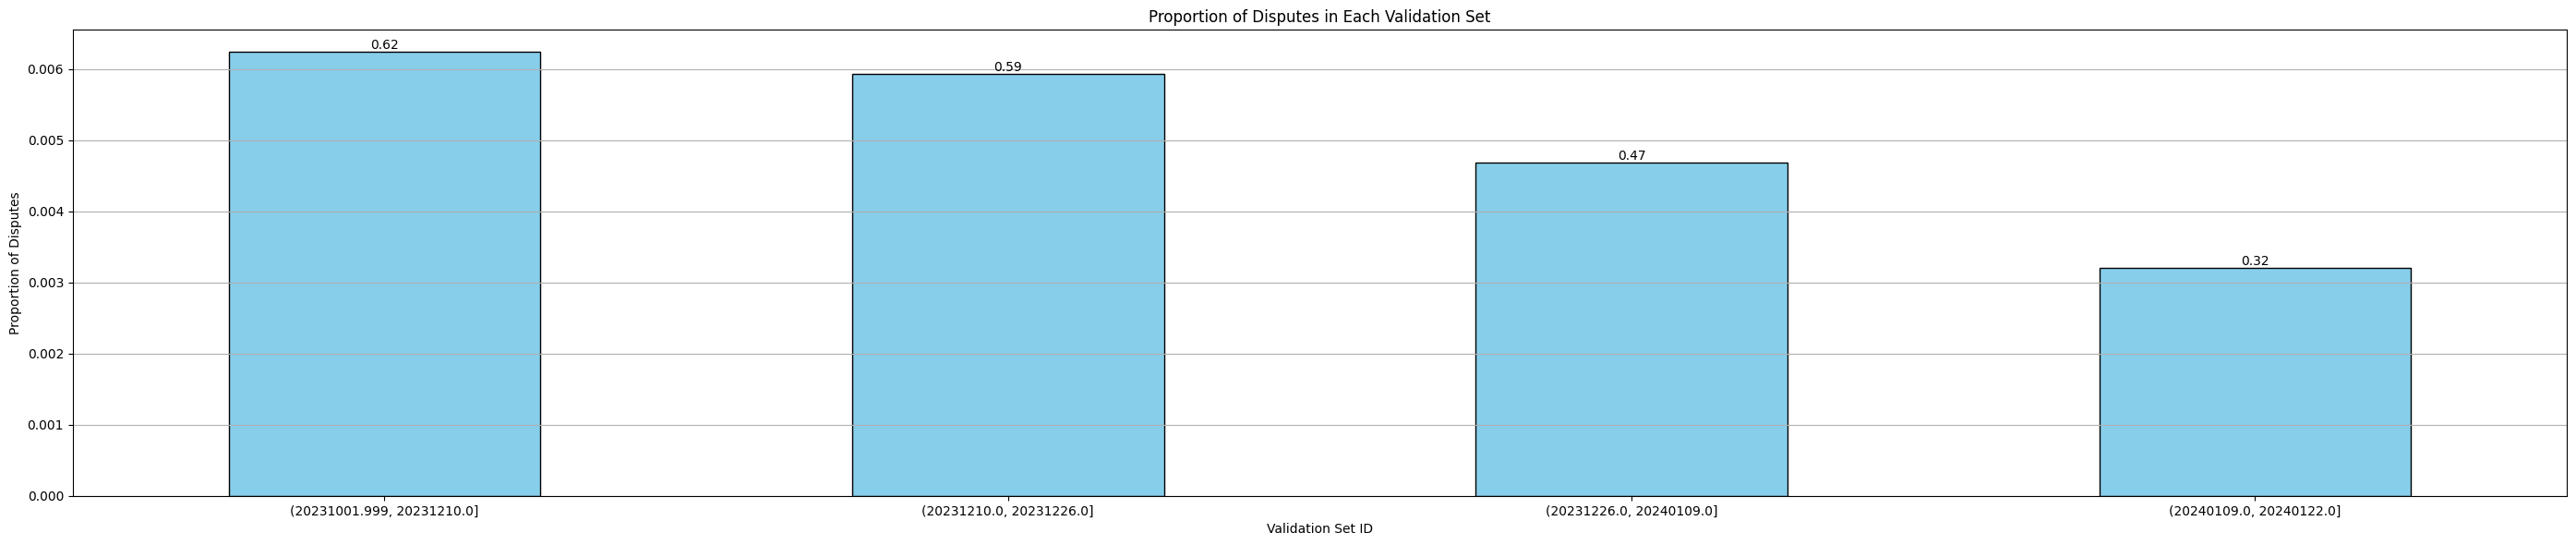

In [54]:
# validation_sets = 3

# # Convert register_time_x to datetime
# result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))

# # Create validation_set_id based on quantiles
# result['validation_set_id'] = pd.qcut(result['date'], validation_sets)

# Calculate the proportion of disputes in each group
proportion_disputes = result.groupby('validation_set_id')['disputer'].mean()

# Plot
plt.figure(figsize=(28, 6))
proportion_disputes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Validation Set ID')
plt.ylabel('Proportion of Disputes')
plt.title('Proportion of Disputes in Each Validation Set')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add gridlines only on the y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Add value labels on top of bars
for i, value in enumerate(proportion_disputes):
    plt.text(i, value, f'{value*100:.2f}', ha='center', va='bottom')

plt.show()


In [55]:
result[payment_cols]

,spent_to_date,max_payment,payments_last_14d,payments_last_7d,games_last_14d,games_last_7d,games_to_date,payments_to_date,spent_last_14d,spent_last_7d,max_daily_spent,daily_pay_std,money_games_to_date,disputer
0,5.00,5.00,0,0,0.0,0.0,235.0,1,0.00,0.00,5.00,1.066004,170.0,0
1,101.00,86.00,0,0,0.0,0.0,651.0,3,0.00,0.00,86.00,18.357678,178.0,0
2,10.00,2.00,0,0,0.0,0.0,1499.0,5,0.00,0.00,10.00,0.426401,941.0,0
3,1.00,1.00,1,0,2073.0,1459.0,2221.0,1,1.00,0.00,1.00,0.213201,437.0,0
4,7.00,7.00,0,0,0.0,0.0,120.0,1,0.00,0.00,7.00,1.492405,45.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38470,3.00,3.00,0,0,0.0,0.0,73.0,1,0.00,0.00,3.00,0.639602,48.0,0
38471,17.00,10.00,0,0,0.0,0.0,946.0,2,0.00,0.00,17.00,2.132007,866.0,0
38472,3.00,3.00,0,0,0.0,0.0,347.0,1,0.00,0.00,3.00,0.639602,176.0,0
38473,1.00,1.00,1,0,806.0,61.0,3339.0,1,1.00,0.00,1.00,0.213201,2697.0,0


In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [
     ('rf', RandomForestClassifier(min_samples_leaf=6, random_state=42)),
     ('rf_2', RandomForestClassifier(min_samples_leaf=30, random_state=42))]

stck = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5), passthrough = True
)


models = {
    'RandomForest_20':            RandomForestClassifier(min_samples_leaf = 20, n_jobs = 5)
    # , 'RandomForest_10':         Ran   domForestClassifier(min_samples_leaf = 6, n_jobs = 5)
    , 'RandomForest_400':         RandomForestClassifier(min_samples_leaf = 5, n_jobs = 5)
    # , 'RandomForest_400':         RandomForestClassifier(min_samples_leaf = 100, n_jobs = 5)
    , 'LogisticRegression':       LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5)
    , 'Stacking':                 stck  # Need to set probability=True for SVC to use predict_proba
    # , 'DecisionTree_350':       DecisionTreeClassifier(min_samples_leaf = 350)
    # , 'DecisionTree_400':       DecisionTreeClassifier(min_samples_leaf = 400)
    , 'DecisionTree_100':         DecisionTreeClassifier(min_samples_leaf = 100)
}

# class_weight
# lr                = LogisticRegression(C = 1.0, max_iter = 180, n_jobs = 5)
# lr                = LogisticRegressionCV(max_iter = 140, l1_ratios = np.logspace(0, 1, 10), cv = 2, n_jobs = 5)
# Random_Forest_40  = RandomForestClassifier(min_samples_leaf = 40, n_jobs = 5)
# Random_Forest_200 = RandomForestClassifier(min_samples_leaf = 200, n_jobs = 5)
# dt                = DecisionTreeClassifier(min_samples_leaf = 350)

# models = [
#     (lr, "Logistic")
#     , (dt, "Classification Tree")
#     , (Random_Forest_40, "Random_Forest_40")
#     , (Random_Forest_200, "Random_Forest_200")
# ]

# Create an empty list to store results
training_results = []

# Loop through each validation set
for validation_set in tqdm(result['validation_set_id'].unique()): 

    # Remove it: 
    train_data = result[result['validation_set_id'] != validation_set][cols + ['disputer']]
    test_data  = result[result['validation_set_id'] == validation_set][cols + ['disputer']]

    # Train and predict with each model
    for model_name, model in models.items():
        X_train, y_train = train_data.drop(columns=['disputer']), train_data['disputer']
        X_test, y_test = test_data.drop(columns=['disputer']), test_data['disputer']
        model.fit(X_train[cols], y_train)
        prob_predictions = model.predict_proba(X_test[cols])[:, 1]

        # Store the predictions along with validation set and model name
        training_results.append(pd.DataFrame({
            'Validation_Set': [validation_set] * len(prob_predictions),
            f'{model_name}_Probability_Predictions': prob_predictions,
            'Actual_Labels': y_test
        }))

# Concatenate all DataFrames into one
training_results = pd.concat(training_results, ignore_index=True)
training_results


100%|██████████| 4/4 [03:31<00:00, 52.99s/it]


,Validation_Set,RandomForest_20_Probability_Predictions,Actual_Labels,RandomForest_400_Probability_Predictions,LogisticRegression_Probability_Predictions,Stacking_Probability_Predictions,DecisionTree_100_Probability_Predictions
0,"(20231001.999, 20231210.0]",0.000014,0,NaN,NaN,NaN,NaN
1,"(20231001.999, 20231210.0]",0.002777,0,NaN,NaN,NaN,NaN
2,"(20231001.999, 20231210.0]",0.005810,0,NaN,NaN,NaN,NaN
3,"(20231001.999, 20231210.0]",0.000000,0,NaN,NaN,NaN,NaN
4,"(20231001.999, 20231210.0]",0.009297,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
192370,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192371,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192372,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192373,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0


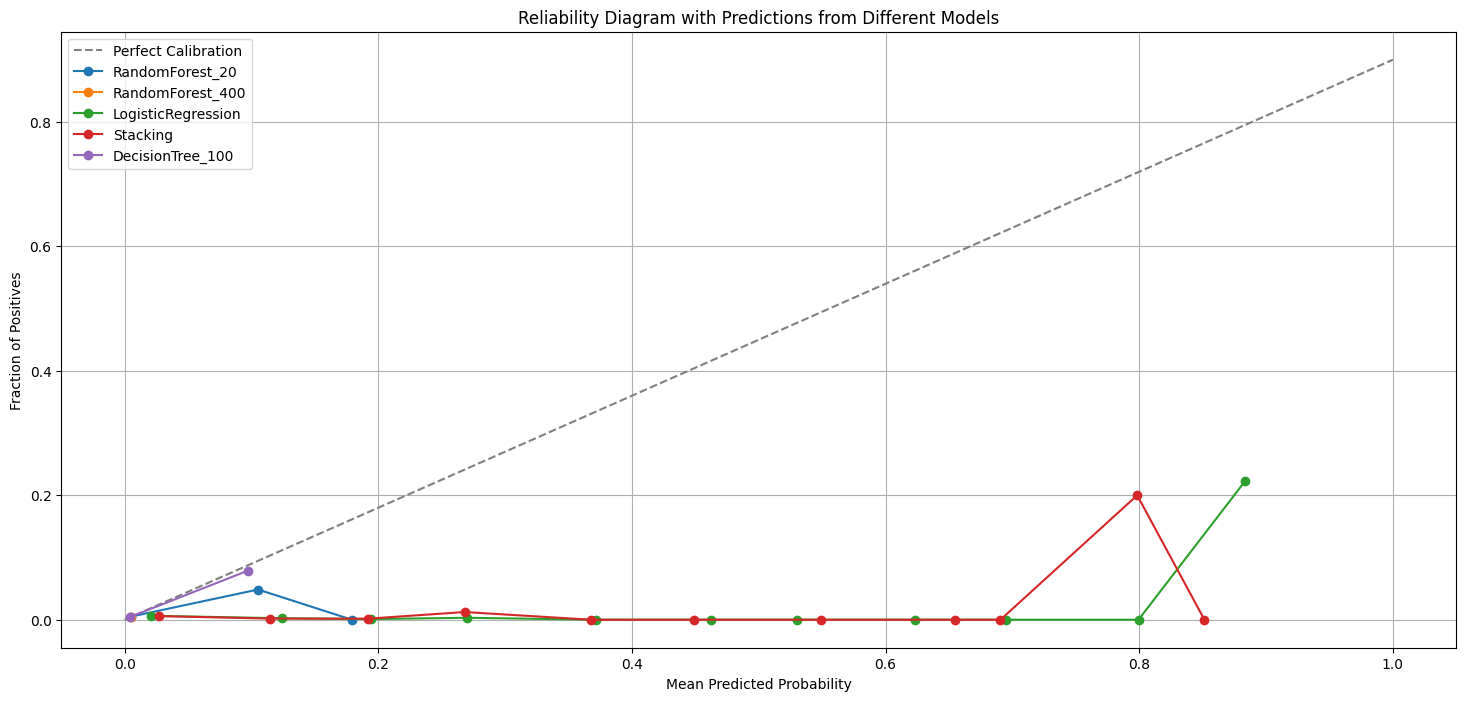

In [58]:

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve for each model
plt.figure(figsize=(18, 8))
plt.plot([0, 1], [0, 0.9], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    model_actual_labels = training_results['Actual_Labels']
    
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(model_actual_labels, model_predictions, n_bins=12, strategy='uniform')

    # Plot reliability diagram for the current model
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=model_name)

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
models.keys()

dict_keys(['RandomForest_20', 'RandomForest_400', 'LogisticRegression', 'Stacking', 'DecisionTree_100'])

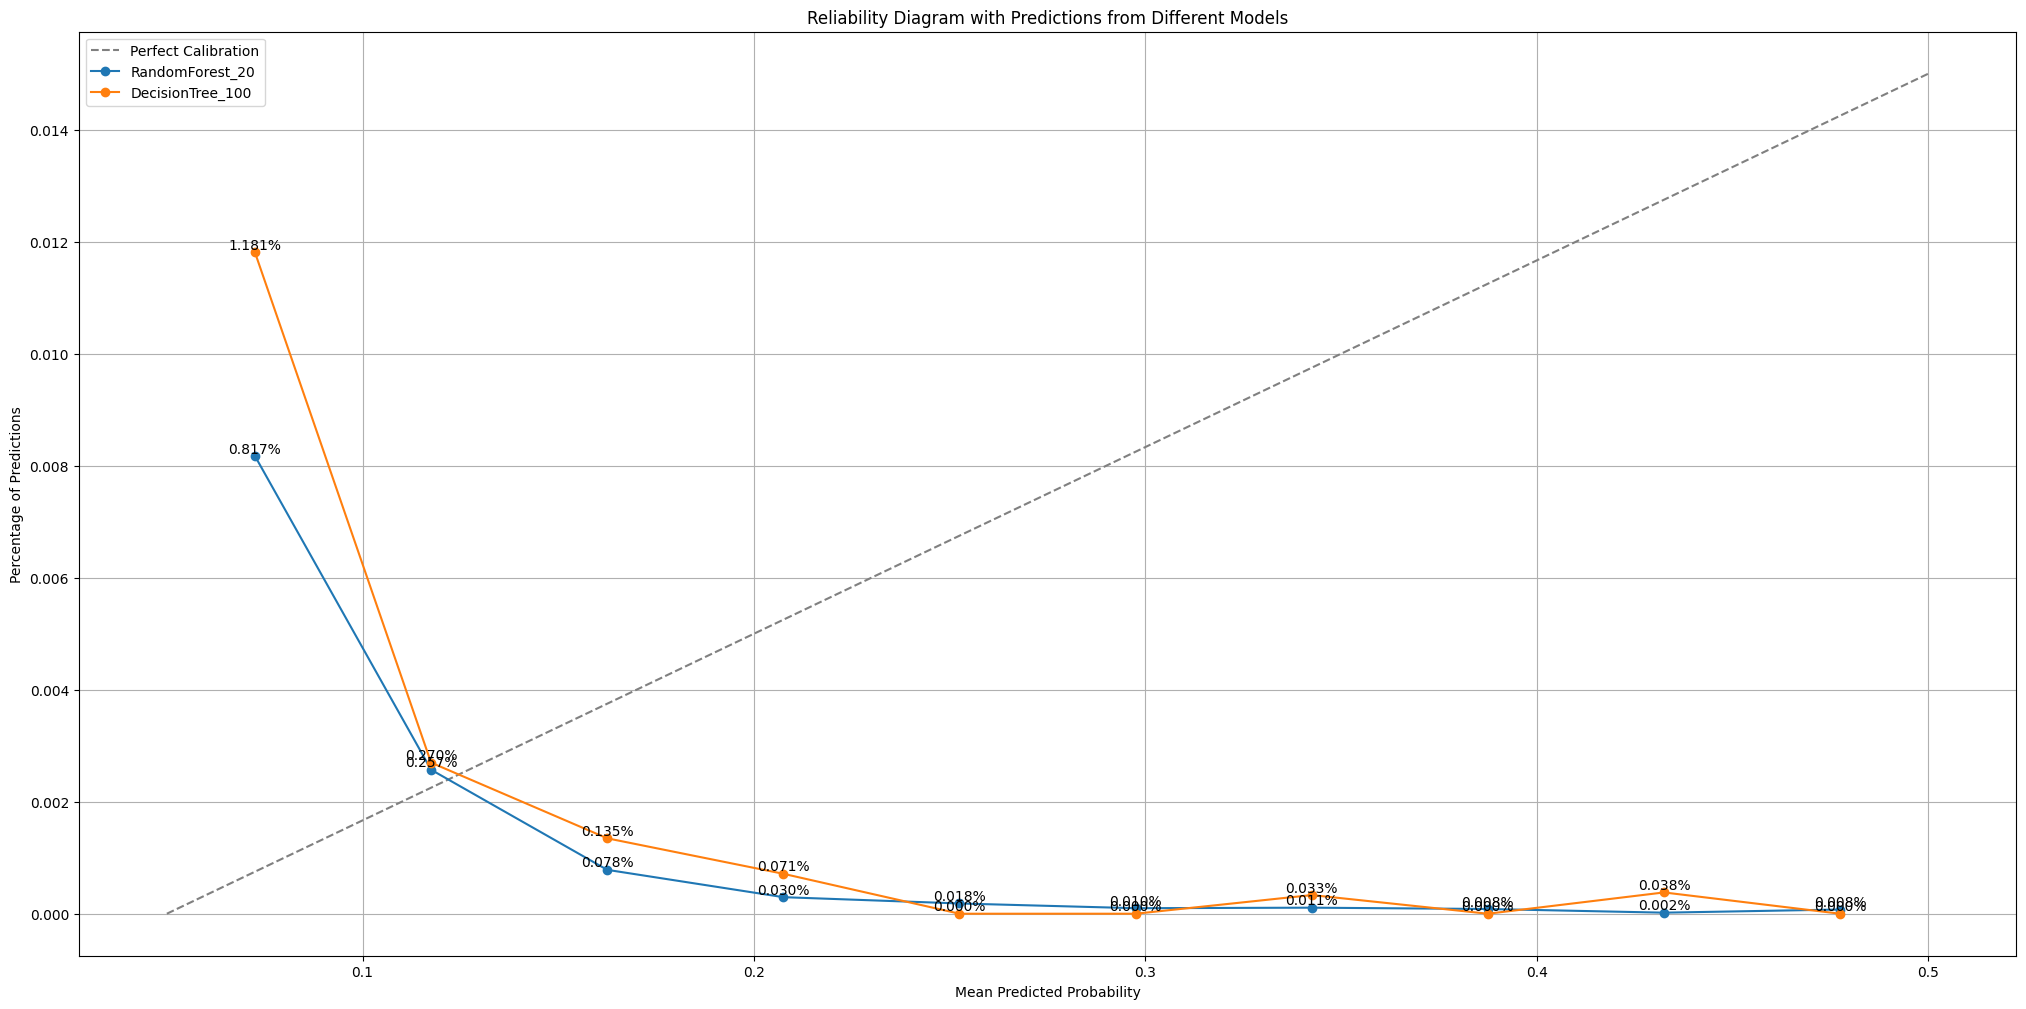

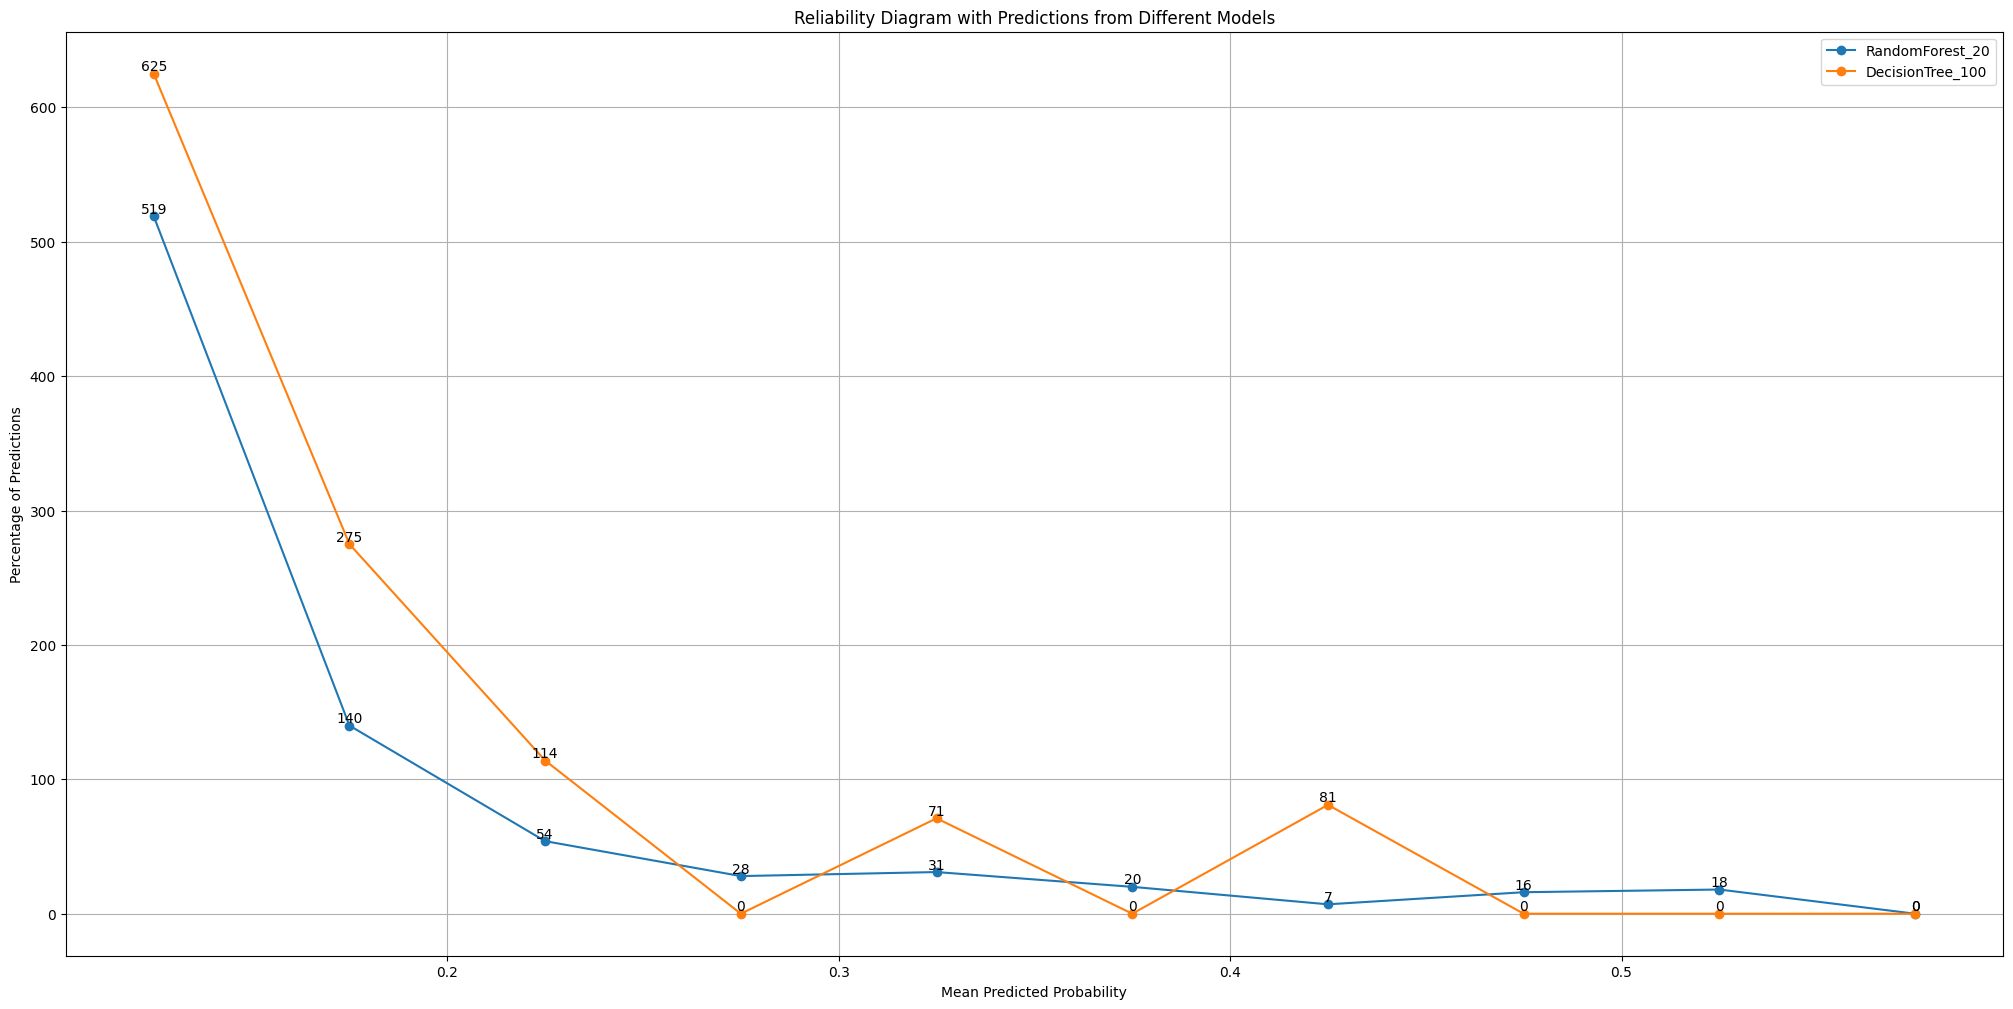

In [50]:
import numpy as np

# Compute calibration curve for each model
plt.figure(figsize=(25, 12))
plt.plot([0.05, 0.5], [0, 0.015], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

# for model_name in models.keys():
for model_name in ['RandomForest_20', 'DecisionTree_100']:
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    
    # Compute histogram of predicted probabilities
    counts, bins = np.histogram(model_predictions, bins=10, range=(0.05, 0.5))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute percentage of predictions in each bin
    percentages = counts / len(model_predictions)
    
    # Plot reliability diagram for the current model
    plt.plot(bin_centers, percentages,  marker='o', linestyle='-', label=model_name)

    # Add labels to the histogram bars
    for i in range(len(bin_centers)):
        plt.text(bin_centers[i], percentages[i], f'{percentages[i]*100:.3f}%', ha='center', va='bottom')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Percentage of Predictions')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(25, 12))

for model_name in ['RandomForest_20', 'DecisionTree_100']:
# for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    
    # Compute histogram of predicted probabilities
    counts, bins = np.histogram(model_predictions, bins=10, range=(0.1, 0.6))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute percentage of predictions in each bin
    percentages = counts
    
    # Plot reliability diagram for the current model
    plt.plot(bin_centers, percentages,  marker='o', linestyle='-', label=model_name)

    # Add labels to the histogram bars
    for i in range(len(bin_centers)):
        plt.text(bin_centers[i], percentages[i], f'{percentages[i]}', ha='center', va='bottom')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Percentage of Predictions')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

#check ensembles: 
training_results['best_two'] = training_results['RandomForest_Probability_Predictions'] + training_results['SVC_Probability_Predictions'].fillna(0)

In [ ]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
depths = [4,5,6, 7]
leaf_sizes = [200]
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)
              

              # try:
              #     model.fit(X_train[cols], y_train)
              #     predictions = model.predict(X_test[cols])
              #     accuracy = accuracy_score(y_test, predictions)
              #     prec = precision_score(y_test, predictions)

              # except:
              #     model = np.nan
              #     predictions = np.nan
              #     mae = np.nan
              #     r2 = np.nan

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])